# Predict Remaining Useful Life Manual

In this notebook, we will work with NASA provided data to accomplish a critical real-world task: predict the remaining useful life of an engine. Our first attempt will be to tackle this problem by hand, with no help from advanced feature engineering tools.

In [1]:
import pandas as pd
import numpy as np

from utils import plot_feature_importances, feature_selection

First we need to read in the data and set the correct columns headers as specified in `readme.txt`. 

In [2]:
operational_settings = ['operational_setting_{}'.format(i + 1) for i in range (3)]
sensor_columns = ['sensor_measurement_{}'.format(i + 1) for i in range(26)]
cols = ['engine_no', 'time_in_cycles'] + operational_settings + sensor_columns
data = pd.read_csv('../input/train_FD002.txt', sep=' ', header=-1, names=cols)
data.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23,sensor_measurement_24,sensor_measurement_25,sensor_measurement_26
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,334,2223,100.00,14.73,8.8071,NaN,NaN,NaN,NaN,NaN
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,330,2212,100.00,10.41,6.2665,NaN,NaN,NaN,NaN,NaN
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,309,1915,84.93,14.08,8.6723,NaN,NaN,NaN,NaN,NaN
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,329,2212,100.00,10.59,6.4701,NaN,NaN,NaN,NaN,NaN
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,309,1915,84.93,14.13,8.5286,NaN,NaN,NaN,NaN,NaN


# Prediction Problem

The training data initially has no prediction problem: we are given the entire operational history of the engine with the last entry representing the last successful measurement before failure. Therefore, we have to come up with our own prediction problem which we do as follows:

1. Select an arbitrary starting date: January 1, 2010
2. Create a time column using the `time_in_cycles` and the knowledge that one cycle takes 10 minutes
3. For each engine, select a random time to use as the prediction point
4. Find the time between the prediction point and the end of life of the engine, this becomes the label
5. Subset the data for each engine to only the times before the prediction point. 

At the end of this process, we will have a labeled training set where each row is one engine and the label is the number of cycles to failure from that point in time. We can then use the past historical data from before the prediction point to train the machine learning model. 

In [3]:
# Pick a starting date (this can be arbitrary)
starting_date = pd.Timestamp(2010, 1, 1)

# Create a time column using the time in cycles * 10 minutes per cycle
data['time'] = [starting_date + pd.Timedelta(x * 10, 'm') for x in data['time_in_cycles']]

data[['engine_no', 'time_in_cycles', 'time']].head()

,engine_no,time_in_cycles,time
0,1,1,2010-01-01 00:10:00
1,1,2,2010-01-01 00:20:00
2,1,3,2010-01-01 00:30:00
3,1,4,2010-01-01 00:40:00
4,1,5,2010-01-01 00:50:00


Now, for each engine, we need to pick a random time to serve as the prediction point. We will impose the limits that we need to have at least 10 measurements before the prediction point.

In [4]:
np.random.seed(50)

# Dataframe to hold results
engines = pd.DataFrame(columns = ['engine_no', 'prediction_point', 'label'])
engine_list = data['engine_no'].unique()

# Iterate through each engine
for engine in engine_list:
    
    # Subset to the engine
    subset = data[data['engine_no'] == engine].copy().sort_values('time')
    
    measurements = subset.shape[0]
    
    # Select a random index for the prediction point
    random_index = np.random.randint(10, measurements - 1)
    
    # Record the predictino point and the label which is the remaining number of cycles
    prediction_point = subset.iloc[random_index, :].copy()['time']
    label = measurements - random_index
    
    # Record the measurements
    engines = engines.append(pd.DataFrame({'engine_no': engine, 'prediction_point': prediction_point, 
                                           'label': label}, index = [0]), 
                             ignore_index = True, sort = True)

In [5]:
engines.to_csv('../input/engines_4.csv', index = False)
engines.head()

,engine_no,label,prediction_point
0,1,30,2010-01-01 20:00:00
1,2,127,2010-01-01 23:50:00
2,3,126,2010-01-01 13:30:00
3,4,155,2010-01-01 13:30:00
4,5,122,2010-01-01 05:30:00


# Limit Data to before prediction point

For each engine, we can only use data from before the prediction point to predict when the engine will fail. We need to subset the `data` table for each engine until only times before the `prediction_point`. 

In [6]:
legal_data = pd.DataFrame(columns = data.columns)

for i, engine in engines.iterrows():
    # Subset to times before the prediction point
    legal_data_subset = data[(data['time'] < engine['prediction_point']) & (data['engine_no'] == engine['engine_no'])].copy()
    
    legal_data = legal_data.append(legal_data_subset, ignore_index = True, sort = True)

In [7]:
train_obs = legal_data.copy()
train_obs.to_csv('../input/train_obs.csv', index = False)
train_obs.head()

,engine_no,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,...,sensor_measurement_26,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,time,time_in_cycles
0,1,34.9983,0.8400,100.0,449.44,1.02,42.02,183.06,2387.72,8048.56,...,NaN,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,2010-01-01 00:10:00,1
1,1,41.9982,0.8408,100.0,445.00,1.02,42.20,130.42,2387.66,8072.30,...,NaN,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,2010-01-01 00:20:00,2
2,1,24.9988,0.6218,60.0,462.54,0.94,36.69,164.22,2028.03,7864.87,...,NaN,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,2010-01-01 00:30:00,3
3,1,42.0077,0.8416,100.0,445.00,1.02,41.96,130.72,2387.61,8068.66,...,NaN,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,2010-01-01 00:40:00,4
4,1,25.0005,0.6203,60.0,462.54,0.94,36.89,164.31,2028.00,7861.23,...,NaN,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,2010-01-01 00:50:00,5


## Metric and Baseline 

Before we go any further, it's important to establish the metric we will use to judge how well our model does and a baseline measure of performance. For this regression problem, we'll use the __Mean Absolute Percentage Error__ (MAPE),  a common metric that is easy to calculate and interpretable. This is the average of the absolute value of (prediction - true value) / true value) and is expressed as a percentage. 

For the naive baseline, we can use two methods:

1. Guess the average value of the label on the training for all instances on the testing set. This will be called `average_guess`.
2. For each engine in the testing data, predict it has reached half its life at the end of the data and will continue to operate for however many cycles it has already operated. This will be called `half_life_guess`.

First we need to read in the testing data which is the same format as the training data.

In [8]:
test_obs = pd.read_csv('../input/test_FD002.txt', sep=' ', header=-1, names=cols)

# Pick a starting date (this can be arbitrary)
starting_date = pd.Timestamp(2010, 1, 1)

# Create a time column using the time in cycles * 10 minutes per cycle
test_obs['time'] = [starting_date + pd.Timedelta(x * 10, 'm') for x in test_obs['time_in_cycles']]

test_obs.to_csv('../input/test_obs.csv', index = False)
test_obs.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23,sensor_measurement_24,sensor_measurement_25,sensor_measurement_26,time
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2319,100.00,28.42,17.1551,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:10:00
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2324,100.00,24.29,14.8039,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:20:00
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2223,100.00,14.98,8.9125,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:30:00
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2212,100.00,10.35,6.4181,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:40:00
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,1915,84.93,14.31,8.5740,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:50:00


In [9]:
train_half_life_guess = train_obs.groupby('engine_no').apply(lambda x: 2 * x.shape[0])
train_baseline = pd.DataFrame({'engine_no': train_obs['engine_no'].unique(), 
                               'half_life_guess': train_half_life_guess.values,
                               'average_guess': engines['label'].mean()})

In [10]:
# Make two baseline guesses
test_half_life_guess = test_obs.groupby('engine_no').apply(lambda x: 2 * x.shape[0])
test_baseline = pd.DataFrame({'engine_no': test_obs['engine_no'].unique(), 
                              'half_life_guess': test_half_life_guess.values,
                               'average_guess': engines['label'].mean()})

The labels for the testing data are in a separate file that we can read in.

In [11]:
test_y = pd.read_csv('../input/RUL_FD002.txt', sep=' ', header=-1, names=['label'], index_col=False)

We'll write a basic function to calculate the mean absolute percentage error and then apply it to the two baselines.

In [12]:
def mape(y_true, pred):
    mape = 100 * np.mean(abs(y_true - pred) / y_true)
    
    return mape

In [13]:
print('The average_guess train MAPE is: {:.2f}.'.format(mape(engines['label'], train_baseline['average_guess'])))
print("The average_guess  test MAPE is: {:.2f}.".format(mape(test_y['label'], test_baseline['average_guess'])))

The average_guess train MAPE is: 158.89.
The average_guess  test MAPE is: 226.44.


In [14]:
print('The half_life train MAPE is: {:.2f}.'.format(mape(engines['label'], train_baseline['half_life_guess'])))
print('The half_life  test MAPE is: {:.2f}.'.format(mape(test_y['label'], test_baseline['half_life_guess'])))

The half_life train MAPE is: 614.89.
The half_life  test MAPE is: 926.51.


# Approach to Feature Engineering

The `train_obs` is now a child table of `engines` because for each unique engine (identified by the `engine_no`), there are multiple rows in the `train_obs`. Our final train dataframe will need to have one unique row for every engine, with the features in the columns, so feature engineering will need to involve aggregating the `train_obs` for every engine. The same operations that are done to `train_obs` will have to be applied to `test_obs` as well because we need to have the same columns in both the train_obsing and testing set! 

In [15]:
train_obs = train_obs.drop(columns = 'time')
train_obs.shape 

(27403, 31)

## Aggregations

As a simple first step, we can perform numerical aggregations of every column in `train_obs` table. If we have no idea what the columns represent, this is a good place to start because it will provide a thorough summary of every column.

In [16]:
# First deal with some annoying type issues
train_obs['sensor_measurement_17'] = train_obs['sensor_measurement_17'].astype(np.float32)
train_obs['sensor_measurement_18'] = train_obs['sensor_measurement_18'].astype(np.float32)
train_obs['time_in_cycles'] = train_obs['time_in_cycles'].astype(np.int32)

# Aggregate each column
train_agg = train_obs.groupby('engine_no').agg(['min', 'max', 'mean', 'sum', 'std'])
train_agg.head()

operational_setting_1                                            \
                            min      max       mean        sum        std   
engine_no                                                                   
1                        0.0000  42.0077  25.414484  3024.3236  15.300117   
2                        0.0000  42.0076  23.734917  3370.3582  14.711035   
3                        0.0002  42.0073  25.365650  2029.2520  13.972098   
4                        0.0004  42.0075  23.640294  1891.2235  15.508015   
5                        0.0008  42.0071  21.721191   695.0781  14.481060   

          operational_setting_2                                       \
                            min     max      mean      sum       std   
engine_no                                                              
1                           0.0  0.8419  0.590210  70.2350  0.315502   
2                           0.0  0.8420  0.571921  81.2128  0.310070   
3                           0.0  0.8420  0.600951  48.0761  0.282966   
4                           0.0  0.8415  0.563961  45.1169  0.323623   
5                           0.0  0.8417  0.528438  16.9100  0.319769   

             ...     sensor_measurement_9                                    \
             ...                      min      max         mean         sum   
engine_no    ...                                                              
1            ...                  7993.23  9051.13  8475.882857  1008630.06   
2            ...                  8005.94  9074.03  8525.690704  1210648.08   
3            ...                  8007.77  9060.51  8496.240750   679699.26   
4            ...                  8004.46  9061.68  8562.626375   685010.11   
5            ...                  8009.47  9066.37  8548.107500   273539.44   

                      time_in_cycles                               
                  std            min  max  mean    sum        std  
engine_no                                                          
1          344.834682              1  119  60.0   7140  34.496377  
2          347.059747              1  142  71.5  10153  41.135953  
3          305.517658              1   80  40.5   3240  23.237900  
4          328.079571              1   80  40.5   3240  23.237900  
5          347.725391              1   32  16.5    528   9.380832  

[5 rows x 150 columns]

In order to better keep track of the columns, we can rename them using a for loop with the original column and then the statistic.

In [17]:
new_cols = []

for col in train_agg.columns.levels[0]:
    for stat in train_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')
        
train_agg.columns = new_cols
train_agg.head()

,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,operational_setting_2-min,operational_setting_2-max,operational_setting_2-mean,operational_setting_2-sum,operational_setting_2-std,...,sensor_measurement_9-min,sensor_measurement_9-max,sensor_measurement_9-mean,sensor_measurement_9-sum,sensor_measurement_9-std,time_in_cycles-min,time_in_cycles-max,time_in_cycles-mean,time_in_cycles-sum,time_in_cycles-std
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,42.0077,25.414484,3024.3236,15.300117,0.0,0.8419,0.590210,70.2350,0.315502,...,7993.23,9051.13,8475.882857,1008630.06,344.834682,1,119,60.0,7140,34.496377
2,0.0000,42.0076,23.734917,3370.3582,14.711035,0.0,0.8420,0.571921,81.2128,0.310070,...,8005.94,9074.03,8525.690704,1210648.08,347.059747,1,142,71.5,10153,41.135953
3,0.0002,42.0073,25.365650,2029.2520,13.972098,0.0,0.8420,0.600951,48.0761,0.282966,...,8007.77,9060.51,8496.240750,679699.26,305.517658,1,80,40.5,3240,23.237900
4,0.0004,42.0075,23.640294,1891.2235,15.508015,0.0,0.8415,0.563961,45.1169,0.323623,...,8004.46,9061.68,8562.626375,685010.11,328.079571,1,80,40.5,3240,23.237900
5,0.0008,42.0071,21.721191,695.0781,14.481060,0.0,0.8417,0.528438,16.9100,0.319769,...,8009.47,9066.37,8548.107500,273539.44,347.725391,1,32,16.5,528,9.380832


That fairly simple operation gave us 150 features that we can use as a main training dataframe. 

### Assess Performance

Let's assess the performance of just these features in a model. We need to make sure to apply the same operations to the testing data.

In [18]:
# Apply same operations to testing data
test_agg = test_obs.groupby('engine_no').agg(['min', 'max', 'mean', 'sum', 'std'])

new_cols = []

for col in test_agg.columns.levels[0]:
    for stat in test_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')
        
test_agg.columns = new_cols
test_agg.head()

,time_in_cycles-min,time_in_cycles-max,time_in_cycles-mean,time_in_cycles-sum,time_in_cycles-std,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,...,sensor_measurement_25-min,sensor_measurement_25-max,sensor_measurement_25-mean,sensor_measurement_25-sum,sensor_measurement_25-std,sensor_measurement_26-min,sensor_measurement_26-max,sensor_measurement_26-mean,sensor_measurement_26-sum,sensor_measurement_26-std
engine_no,,,,,,,,,,,,,,,,,,,,,
1,1,258,129.5,33411,74.622383,0.0002,42.0078,24.157602,6232.6614,14.625359,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
2,1,55,28.0,1540,16.020820,0.0005,42.0079,26.512127,1458.1670,15.193411,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
3,1,165,83.0,13695,47.775517,0.0001,42.0078,22.663222,3739.4316,15.144796,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4,1,86,43.5,3741,24.969982,0.0002,42.0078,24.061074,2069.2524,14.675946,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
5,1,148,74.5,11026,42.868014,0.0000,42.0074,23.739297,3513.4160,14.189404,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

mape_scorer = make_scorer(mape, greater_is_better = False)

def evaluate(train, train_labels, test, test_labels):
    """Evaluate a training dataset with a standard sklearn model"""
    
    # Use the same model for each training set for now
    model = RandomForestRegressor(n_estimators = 100, 
                                  random_state = 50, n_jobs = -1)
    
    train = train.replace({np.inf: np.nan})
    test = test.replace({np.inf: np.nan})
    
    feature_names = list(train.columns)
    
    # Impute the missing values
    imputer = Imputer(strategy = 'median', axis = 1)
    train = imputer.fit_transform(train)
    test = imputer.transform(test)
    
    
    # Fit on the training data and make predictions
    model.fit(train, train_labels)
    preds = model.predict(test)
    
    cv_score = -1 * cross_val_score(model, train, train_labels, 
                                    scoring = mape_scorer, cv = 5)
    
    # Calculate the performance
    mape_score = mape(test_labels, preds)
    print('5-fold CV MAPE: {:.2f} with std: {:.2f}'.format(
                                                                                   cv_score.mean(), 
                                                                                   cv_score.std()))
    print('Test MAPE: {:.2f}.'.format(mape_score))
    feature_importances = pd.DataFrame({'feature': feature_names, 
                                        'importance': model.feature_importances_})
    
    return preds, feature_importances

In [20]:
# Remove the engine number since it should not be predictive
train = train_agg.reset_index(drop = True)
test = test_agg.reset_index(drop = True)

train_labels = engines['label']
test_labels = test_y['label']

preds, fi = evaluate(train, train_labels, test, test_labels)

5-fold CV MAPE: 44.56 with std: 3.22
Test MAPE: 232.47.


Our initial try did not even do much better than the baseline! To get a sense of what might be wrong, we can plot the predictions.

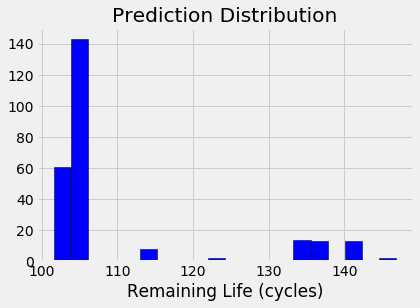

In [21]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

plt.hist(preds, bins = 20, color = 'blue', edgecolor = 'k')
plt.title('Prediction Distribution'); plt.xlabel('Remaining Life (cycles)');

We can also plot the 10 most important features to see what the model thinks are the most relevant features we made.

,feature,importance,importance_normalized,cumulative_importance
0,operational_setting_2-sum,0.214550,0.214550,0.214550
1,operational_setting_1-sum,0.090473,0.090473,0.305023
2,sensor_measurement_4-max,0.079222,0.079222,0.384245
3,sensor_measurement_16-sum,0.042174,0.042174,0.426419
4,sensor_measurement_15-sum,0.041890,0.041890,0.468308
5,sensor_measurement_12-sum,0.032634,0.032634,0.500942
6,sensor_measurement_11-max,0.031334,0.031334,0.532275
7,sensor_measurement_8-max,0.029826,0.029826,0.562102
8,sensor_measurement_15-max,0.021419,0.021419,0.583521
9,sensor_measurement_3-max,0.018774,0.018774,0.602295


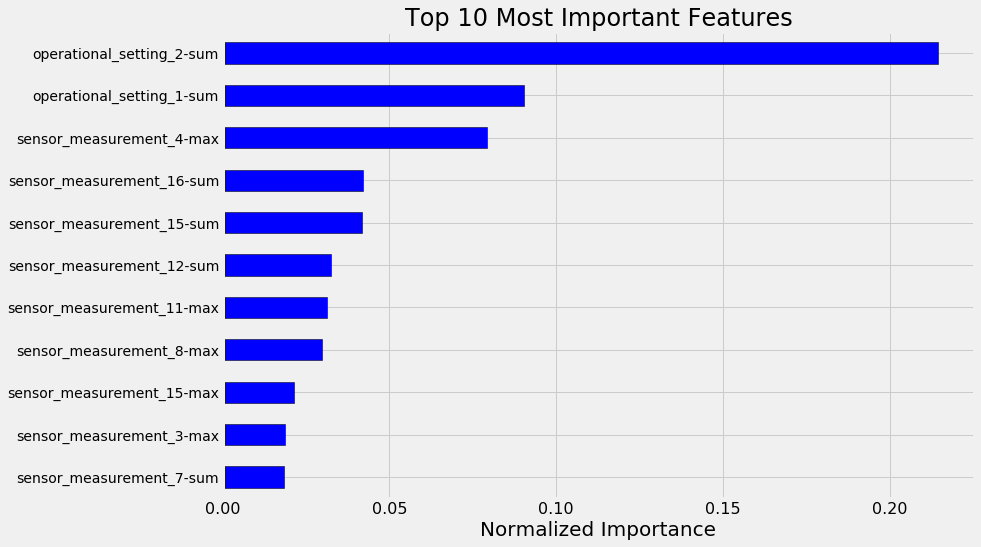

In [22]:
norm_fi = plot_feature_importances(fi, 10)
norm_fi.head(10)

It seems the model was not able to learn, predicting nearly the same value for all engines. One possible issue is the presence of too many irrelevant features.

## Feature Selection

Feature selection is nearly as important as feature engineering because irrelevant features can slow down model training, lead to poorer performance on the test set, and less model interpretability. Below, we apply four methods of feature selection (see the `utils.py` file and the `feature_selection` function for details) to the dataset and then re-evaluate. Feature selection here is composed of:

1. Remove columns that have exactly the same values
2. Remove columns with only a single unique value
3. Remove columns with more than 90% missing values
4. Remove one of each pair of columns with a correlation greater than 0.95.

In [23]:
train_fs = feature_selection(train)
test_fs = test[train_fs.columns]

Original shape:  (260, 150)
5  non-unique valued columns.
20 missing columns with threshold: 90.
10 zero variance columns.
73 collinear columns removed with threshold: 0.95.
Total columns removed:  108
Shape after feature selection: (260, 42).


In [24]:
preds, fi = evaluate(train_fs, train_labels, test_fs, test_labels)

5-fold CV MAPE: 46.62 with std: 4.46
Test MAPE: 51.48.


The performance increases significantly! This small example highlights the importance of proper feature selection. 

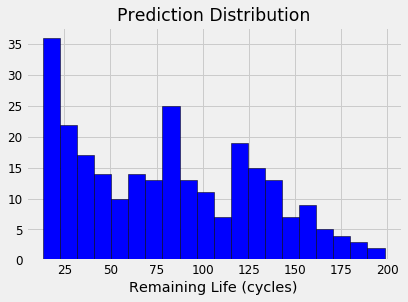

In [25]:
plt.hist(preds, bins = 20, color = 'blue', edgecolor = 'k')
plt.title('Prediction Distribution'); plt.xlabel('Remaining Life (cycles)');

,feature,importance,importance_normalized,cumulative_importance
0,time_in_cycles-sum,0.294993,0.294993,0.294993
1,sensor_measurement_16-sum,0.266038,0.266038,0.561032
2,sensor_measurement_11-max,0.080718,0.080718,0.641750
3,sensor_measurement_15-max,0.072387,0.072387,0.714137
4,sensor_measurement_13-max,0.025355,0.025355,0.739492


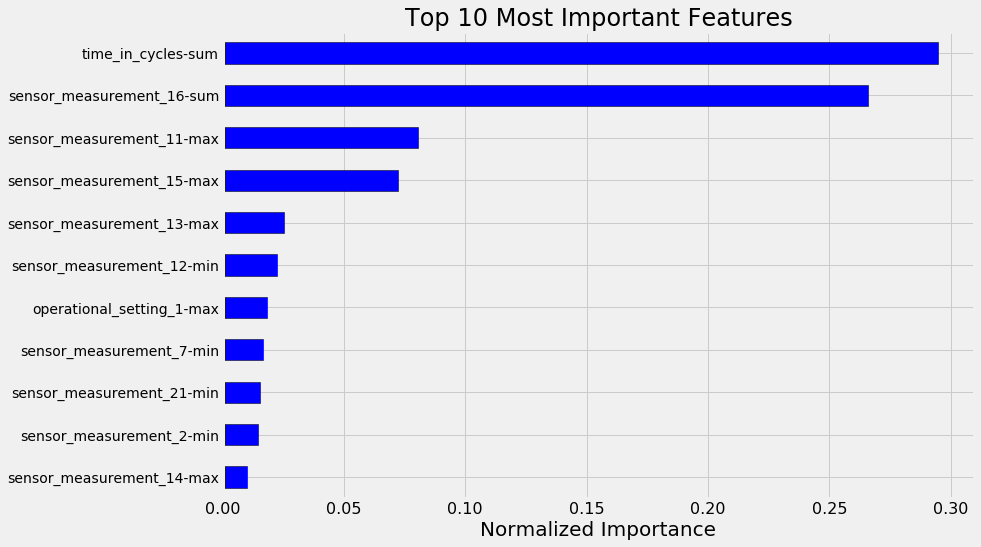

In [26]:
norm_fi = plot_feature_importances(fi, 10)
norm_fi.head()

The most important feature now makes more sense: the total previous cycles of the engine is the greatest predictor of how much longer the engine will last. 

__Through feature selection, we went from a model that was no better than a naive guess, to a model that reduced the error of the guess by more than 75%!__

In [28]:
train_fs.to_csv('../input/simple_manual_features.csv')

## More Advanced Feature Engineering

To try and build an even better model, we can apply more advanced feature engineering techniques. Since our data is in a time-series, we can apply any time-series operation to each engine. For example, we can find the percentage change, the cumulative sum, and the cumulative mean for each engine.

In [ ]:
train_obs = train_obs.sort_values(['engine_no', 'time_in_cycles'])
train_obs.head()

In [ ]:
train_exp = train_obs.copy()

for col in train_obs:
    train_exp[f'{col}_pct_change'] = train_obs.groupby('engine_no')[col].apply(lambda x: x.pct_change())
    train_exp[f'{col}_cum_sum'] = train_obs.groupby('engine_no')[col].apply(lambda x: np.cumsum(x))
    
train_exp.head()

Now we can take this data and aggregate it to get a single dataframe for testing.

In [ ]:
def agg_and_rename(df, agg_variable):
    """Function to aggregate a dataframe"""
    
    df_agg = df.groupby(agg_variable).agg(['min', 'max', 'mean', 'sum', 'std'])

    new_cols = []

    # Create a rename set of columns
    for col in df_agg.columns.levels[0]:
        for stat in df_agg.columns.levels[1]:
            new_cols.append(f'{col}-{stat}')

    df_agg.columns = new_cols
    
    return df_agg

In [ ]:
train_exp_agg = agg_and_rename(train_exp, 'engine_no')
train_exp_agg.head()

Now we apply the same operation to the testing data, do feature selection on the training data, subset the testing data to the same columns as the training data, and evaluate!

In [ ]:
test_obs.drop(columns = 'time', inplace = True)
test_exp = test_obs.copy()

for col in test_obs:
    test_exp[f'{col}_pct_change'] = test_obs.groupby('engine_no')[col].apply(lambda x: x.pct_change())
    test_exp[f'{col}_cum_sum'] = test_obs.groupby('engine_no')[col].apply(lambda x: np.cumsum(x))

test_exp_agg = agg_and_rename(test_exp, 'engine_no')

In [ ]:
train_exp_agg_fs = feature_selection(train_exp_agg, 90, 0.95)
test_exp_agg_fs = test_exp_agg[train_exp_agg_fs.columns]

In [ ]:
preds, fi = evaluate(train_exp_agg_fs, train_labels, test_exp_agg_fs, test_labels)

It appears we may have reached the limits of what we can do with feature engineering given that we added more features and yet the performance did not increase. 

In [ ]:
norm_fi = plot_feature_importances(fi, 10)
norm_fi.head()

The model has about the same performance, but now is less interpretable because we have created more complicated features! In most cases, we want to choose the less complicated model especially if the performance is equivalent to a more complicaated model that we cannot interpret. 

## KMeans clustering and Time-Series Analysis

We can try one more manual feature engineering effort using clustering and a time-series complexity measurement. This time, we will not use the `pct_change` and `cum_sum` because these features did not improve the model. 

* Clustering: First we will cluster the observations into 10 unique clusters. We can then perform numerical aggregations on these clusters to get the information into a training dataframe. 
* Time-series analysis: Using the `tsfresh` package, we can apply a number of functions such as `number_peaks` and `cid_ce`. 

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters = 10)

# Need to impute the missing values
imputer = Imputer(strategy='median')
train_cluster = imputer.fit_transform(train_obs.drop(columns = ['engine_no', 'time_in_cycles']))

# Create a new column with the cluster label
train_obs['cluster'] = kmeans.fit_predict(train_cluster)

Next we apply the same procedure to the testing data (but without the `fit` since we can only `fit` to training data).

In [ ]:
test_cluster = imputer.transform(test_obs.drop(columns = ['engine_no', 'time_in_cycles']))
test_obs['cluster'] = kmeans.predict(test_cluster)

### Visualize Clusters
 
We can try to visualize the clusters by applying a UMAP embedding to the data.

In [ ]:
import umap

reducer = umap.UMAP(n_components = 3)
train_embedding = reducer.fit_transform(train_cluster)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection='3d')

cmap = plt.get_cmap('tab10', 10)
p = ax.scatter(train_embedding[:, 0], train_embedding[:, 1], train_embedding[:, 2], 
               c = train_obs['cluster'], cmap = cmap)
plt.title('UMAP Embedding Showing KMeans Cluster Assignments')
fig.colorbar(p);

The UMAP embedding shows the clusters pretty clearly separate the observations, so perhaps they can be useful. By clustering, we're assuming that the engines share operating behavior and that this information is related to the label for the engines. 

To get one observation per engine, we again have to aggregate by the `engine_no`. This time we will have five extra columns with the aggregations of the cluster assignments. 

In [ ]:
train_agg = agg_and_rename(train_obs, 'engine_no')
train_agg.head()

In [ ]:
test_agg = agg_and_rename(test_obs, 'engine_no')

For the time series operations, we have any number of choices we can make from `tsfresh`. Each of these operations is applied to a single time-series and generates one number. Therefore, to apply them, we group by the the `engine_no` and then apply the operation to get a single observation per engine. We will choose five different operations:

1. `cid_ce`: measures the complexity of a time series
2. `number_peaks`: measures the number of peaks where a peak is bigger than `n` neighbors to the right and left
3. `last_location_of_maximum`: locates the last occurrence of the maximum value in the time series
4. `skewness`: the Fisher-Pearson skewness of the time series
5. `sample_entropy`: the sample entropy of the time series

All of these will be calculated for each operational setting and each sensor measurement giving us 5 new columns for each of the 29 original features (145 total features).

In [ ]:
from tsfresh.feature_extraction.feature_calculators import (cid_ce, number_peaks, 
                                                             last_location_of_maximum, 
                                                             skewness, sample_entropy)

To avoid the issue of passing multiple functions to `agg` with the same name `lambda`, we have to create lambda functions and then give them custom names. `cid_ce` and `number_peaks` both have required arguments but the other functions only need a time-series.

In [ ]:
cid_ce_func = lambda x: cid_ce(x, normalize=False)
cid_ce_func.__name__ = 'cid_ce'

n_peaks = lambda x: number_peaks(x, n = 5)
n_peaks.__name__ = 'number_peaks'

# Apply the five operations
ts_values = train_obs.drop(columns = ['time_in_cycles']).groupby('engine_no').agg([cid_ce_func, n_peaks, 
                                                                                   last_location_of_maximum,
                                                                                   skewness, sample_entropy])
ts_values.head()

In [ ]:
new_cols = []

for col in ts_values.columns.levels[0]:
    for stat in ts_values.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')

In [ ]:
ts_values.columns = new_cols

This dataframe can then be joined to the training data because there is one observation for each engine.

In [ ]:
train_obs['engine_no'] = train_obs['engine_no'].astype(np.int32)

In [ ]:
train_agg = train_agg.merge(ts_values, on = 'engine_no', how = 'outer')
train_agg.head()

Then we apply the same operations to the testing data.

In [ ]:
# Apply the five operations
ts_values_test = test_obs.drop(columns = ['time_in_cycles']).groupby('engine_no').agg([cid_ce_func, n_peaks, 
                                                                                   last_location_of_maximum,
                                                                                   skewness, sample_entropy])

# Rename the columns
new_cols = []

for col in ts_values_test.columns.levels[0]:
    for stat in ts_values_test.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')
        
        
ts_values_test.columns = new_cols

In [ ]:
test_agg = test_agg.merge(ts_values_test, on = 'engine_no', how = 'outer')

Finally, we can apply feature selection and then evalute the new set of features.

In [ ]:
train_agg_fs = feature_selection(train_agg, 90, 0.95)
final_features = list(train_agg_fs.columns)
test_agg_fs = test_agg[train_agg_fs.columns]

In [ ]:
preds = evaluate(train_agg_fs, train_labels, test_agg_fs, test_labels)

## Random Search

The model we used to evaluate the features was an unoptimized random forest. In order to make sure we are getting the most out of the model, we should perform random search over the hyperparameters. To do this, we can use `RandomizedSearchCV` from Scikit-Learn. The process is as follows:

1. Select a metric: we already made a scorer using MAPE
2. Define a hyperparameter grid over the search domain for the following hyperparameters:
    * `n_estimators`
    * `max_depth`
    * `min_samples_leaf`
    * `max_features`
3. Run random search for 100 iterations
4. Extract the best hyperparameters and use these for the final model

__We will only use the random search on the final set of features because these had the best performance on the training data.__

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

scorer = mape_scorer

param_grid = {
    'n_estimators': [int(x) for x in np.linspace(50, 1000, num = 100)],
    'max_depth': [None] + [int(x) for x in np.linspace(4, 20)],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['auto', 'sqrt', 0.5, 'log2', None]
}

In [ ]:
# Make a model 
reg = RandomForestRegressor(n_jobs = -1, random_state = 50)

# RandomizedSearchCV object
random = RandomizedSearchCV(reg, param_grid, n_iter = 100, scoring = scorer, 
                            verbose = 1, n_jobs = -1, cv = 5, random_state = 50)

# Fit on the training data
random.fit(train_agg_fs, train_labels)

In [ ]:
random.best_params_

#### Evaluate Best Model

Finally, we will use the set of feature from aggregations, kmeans clustering, and time-series analysis along with the optimal hyperparameters to train one final model. Then we can look at the final feature importances.

In [ ]:
best_score = -1 * random.best_score_
best_score_std = random.cv_results_['std_test_score'][np.argmax(random.cv_results_['mean_test_score'])]
best_model = random.best_estimator_

# Need to impute the values on the test data
imputer.fit(train_agg_fs)
test_agg_fs = test_agg_fs.replace({np.inf: np.nan})
test_agg_fs = imputer.transform(test_agg_fs) 

In [ ]:
# Make predictions on the. test data
preds = best_model.predict(test_agg_fs)
final_mape = mape(test_labels, preds)

print('5-fold Cross Validation MAPE: {:.2f} with std: {:.2f}'.format(best_score, best_score_std))
print('Test MAPE: {:.2f}.'.format(final_mape))

The 5-fold cross validation MAPE stayed about the same, but the Test MAPE has slightly decreased over the unoptimized random forest. 

In [ ]:
fi = pd.DataFrame({'feature': final_features, 'importance': best_model.feature_importances_})
norm_fi = plot_feature_importances(fi)

It does not appear that the KMeans clustering had much effect on the model because none of the top 15 most important features involve the cluster. The complexity and entropy both make it into the top features suggesting these may have a beneficial effect on the model. __Overall, the simple aggregations and the more complex time-series methods, along with random search over the hyperparameters yields the best model performance on the test data__.

# Conclusions 

After several rounds of manual feature engineering following are the results:

| Feature Set                                                      	| Model                   	| Number of Features   (before selection) 	| Number of Features   (after selection) 	| Time to Build 	| 5-fold Train CV MAPE 	| Test MAPE 	|
|------------------------------------------------------------------	|-------------------------	|-----------------------------------------	|----------------------------------------	|---------------	|----------------------	|-----------	|
| Baseline Average Train Label Guess                               	| -                       	| -                                       	| -                                      	| 15 seconds    	| 158.89 (0.00)        	| 226.44    	|
| Baseline Half Life Guess                                         	| -                       	| -                                       	| -                                      	| 30 seconds    	| 614.89 (0.00)        	| 926.51    	|
| Simple Aggregations (No Feature Selection)                       	| Default Random Forest   	| 150                                     	| 150                                    	| 60 minutes    	| 44.56 (3.22)         	| 232.47    	|
| Simple Aggregations (No Feature Selection)                       	| Default Random Forest   	| 150                                     	| 42                                     	| 90 minutes    	| 46.62 (4.46)         	| 51.48     	|
| Simple Aggregations +  Percent Change and Cumuluative Sum        	| Default Random Forest   	| 455                                     	| 88                                     	| 120 minutes   	| 46.13 (4.93)         	| 53.11     	|
| Simple Aggregations + KMeans Clustering and Time-Series Analysis 	| Default Random Forest   	| 305                                     	| 88                                     	| 120 minutes   	| 45.36 (5.35)         	| 50.33     	|
| Simple Aggregations + KMeans Clustering and Time-Series Analysis 	| Optimized Random Forest 	| 305                                     	| 88                                     	| 120 minutes   	| 45.33 (5.98)         	| 48.54     	|

The best performing model used the simple aggregations, KMeans clustering, and time-series analysis features along with the optimized random forest model. These results highlight several important takeaways:

1. Feature Engineering is critical. A simple baseline guess is worthless in terms of predictive power
2. Feature Selection is critical. The simple aggregation set of features resulted in significant overfitting to the training set before proper feature selection was applied. 
3. Beyond a certain point, adding more complex features has diminishing returns to performance gains for this problem.
4. Model hyperparameter tuning can improves performance, but the gains are much smaller than those from feature engineering.

There were many more operations we could have applied to the data to generate features that we did not. For manual feature engineering, we are limited only by our imagination and patience. However, once we get to a certain level of performance, squeezing out every last bit of accuracy is secondary to [model interpretability](https://www.oreilly.com/learning/introduction-to-local-interpretable-model-agnostic-explanations-lime). We might want to forgo complex operations and sacrifice a minor bit of performance in order to create a more interpretable model. 

Overall, manual feature engineering was effective for this problem and resulted in a model that significantly outperforms the baseline. Nonetheless, manual feature engineering is still time-consuming, error-prone, and does not translate between problems because we have to completely re-write the code. In the next notebook, we will implement automated feature engineering using [Featuretools](https://www.featuretools.com/), which is significantly more efficient, can be applied to any dataset with only minor changes in syntax, and will allow us to create hundreds or thousands of features which are not limited by our creavity or our time.